In [1]:
import numpy as np
import itertools 
from math import comb
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import matplotlib as mpl
from Adversary import Adversary, Problem
from ElementDistinctness import ED
from Solvers import adv_solver, span_solver

In [26]:
# generates a list of all partial injective functions [n] to [n] with domain size k
# format: (inputs, outputs) such that f(intputs[i]) = f(outputs[i])
def all_injective(n, k):
    print(k)
    injectives_single = list(itertools.combinations(list(range(n)), k))
    ranges = list(itertools.permutations(list(range(n)), k))
    return list(set(itertools.product(injectives_single, ranges)))

# outputs ids for the functions from family agree with the partial function
def get_agreeable_indices(partial_injective, family):
    indices = []
    for function, i in family.items():
        # print(i, function)
        agree = True
        for index, output in zip(*partial_injective):
            if function[index] != output:
                agree = False
                break

        if agree:
            indices.append(i)
    return indices

# outputs the v_a and w_a vectors. In retrospect, these vectors aren't orthogonal
def get_basis_vector(partial_injective, family, n):
    agreeable = get_agreeable_indices(partial_injective, family)
    basis_vector = np.zeros(len(family))
    for i in agreeable:
        # print('ag', len(agreeable))
        basis_vector[i] = 1
    return basis_vector / np.sqrt(len(agreeable))
    


# outputs projection onto the space spanned by no-instances that agree with k-sized partial injective functions
def no_space_projection(k, no_fam, n):
    projection = np.zeros((len(no_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    no_vects = [get_basis_vector(injective, no_fam, n) for injective in all_partial_injectives]
    no_vects = np.array(no_vects).T

    # print(no_vects)
    ortho_basis = scipy.linalg.orth(no_vects)
    # print(ortho_basis)
    # print('mat', ortho_basis)
    basis_vectors = [np.array([ortho_basis.T[i]]).T for i in range(ortho_basis.shape[1])]
    # print(ortho_basis)
    
    for v in basis_vectors:
        # print(v)
        # print(v@ v.T)
        # plt.imshow( v@ v.T)
        # plt.show()
        projection += v @ v.T
    plt.imshow(projection)
    return projection
                          
def L_matrix(k, yes_fam, no_fam, n):
    projection = np.zeros((len(yes_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    for injective_1 in all_partial_injectives:
        w = get_basis_vector(injective_1, yes_fam, n)
        v = get_basis_vector(injective_1, no_fam, n)
        # plt.imshow(np.asmatrix(v).T)
        # plt.show()
        # print(w.T)
        # print(v)
        # input(np.asmatrix(w).T @ np.asmatrix(v))
        projection = projection + np.asmatrix(w).T @ np.asmatrix(v)
        
    return projection
    
def H_projection(k, no_fam, n):
    A_k = no_space_projection(k, no_fam, n)
    if k==0:
          return A_k
    I = np.identity(len(no_fam))
    A_km1 = no_space_projection(k-1, no_fam, n)
    return 2 *(A_k- A_k @ scipy.linalg.pinv(A_k+ (I-A_km1))) @ A_k

def get_adversary_matrix(n, yes_fam, no_fam):
    adv_mat = np.zeros((len(yes_fam), len(no_fam)))
    target = int(n**(2/3))+ 1
    print('target', target)
    for k in range(target):
        adv_mat = adv_mat + (target - k) * L_matrix(k, yes_fam, no_fam, n) @ H_projection(k, no_fam, n)
    return adv_mat
    
    


In [27]:
def partial_vectors(k, yes_fam, no_fam, n):
    projection = np.zeros((len(yes_fam), len(no_fam)))
    all_partial_injectives = all_injective(n, k)
    W = []
    V = []
    for injective_1 in all_partial_injectives:
        w = get_basis_vector(injective_1, yes_fam, n)
        v = get_basis_vector(injective_1, no_fam, n)
        W.append(w)
        V.append(v)
    return np.array(W).T, np.array(V).T

def plot_partial_vectors(k, yes_fam, no_fam, n):
    fam = [yes_fam, no_fam]
    fig, axs = plt.subplots(2, 1)
    vects = partial_vectors(k, yes_fam, no_fam, n)
    for i in range(len(axs)):
        ax = axs[i]
        ax.imshow(vects[i])
        ax.tick_params(axis='both', which='major', labelsize=3)
        ax.tick_params(axis='both', which='minor', labelsize=1)
        ax.set_xticks(np.arange(vects[i].shape[1]), minor=False)
        ax.set_yticks(np.arange(vects[i].shape[0]), minor=False)
        y_labels = [to_str(func) for func in fam[i]]
        x_labels = [to_str(dom) + '-->' + to_str(ran) for dom, ran in all_injective(n, k)]
        print(y_labels)
        print(all_injective(n, k))
        ax.set_yticklabels(y_labels)
        ax.set_xticklabels(x_labels)
        # ax.set_xticklabels(xlabels, rotation=90)
        # ax.set_yticklabels(ylabels)
    plt.show()

    

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
target 3
0
0
1
1
0
2
2
1


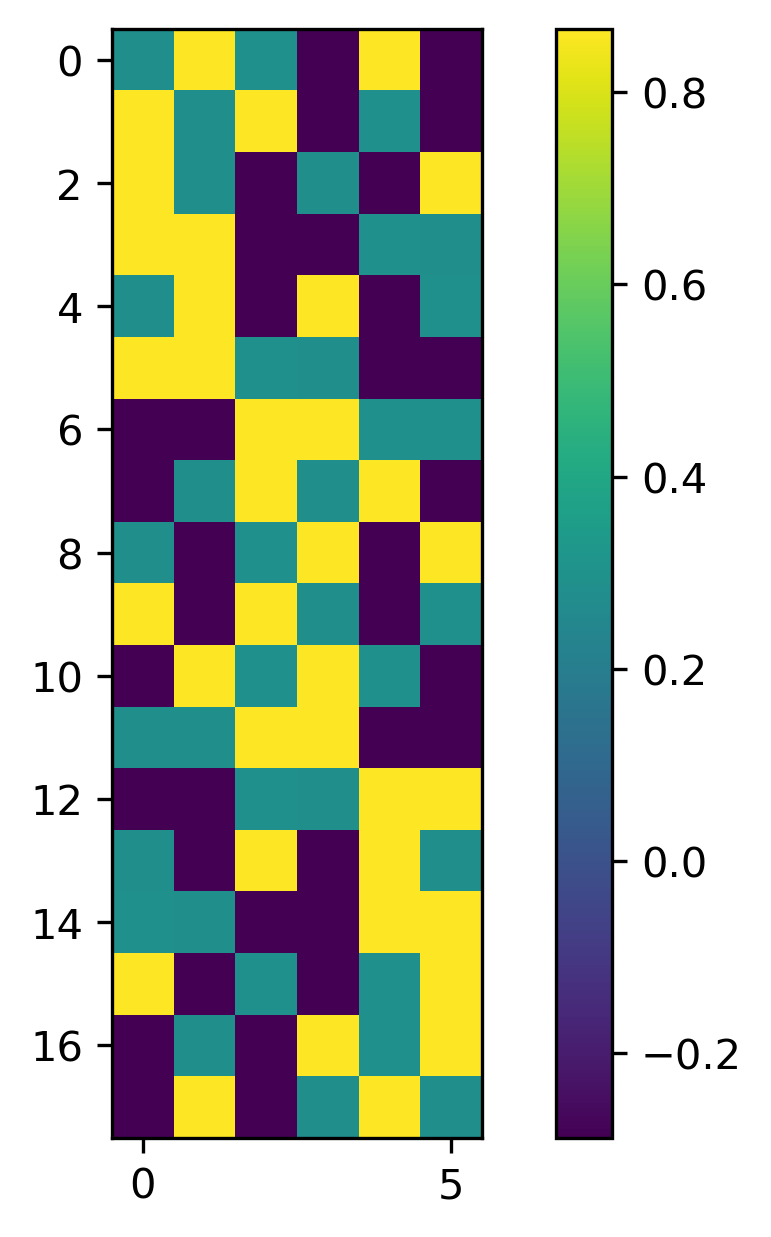

In [28]:
n=3
problem = ED(n)
yes_dict = {problem.yes_instances[i]: i for i in range(problem.yes_len)}
no_dict = {problem.no_instances[i]: i for i in range(problem.no_len)}
G = get_adversary_matrix(n, yes_dict, no_dict)

# print(no_family, '\n', yes_family)
adv = Adversary(problem, lambda yes, no: G[yes_dict[yes], no_dict[no]])
plt.imshow(adv.matrix)
plt.colorbar()

# for i in range(3):
    # plt.imshow(H_projection(i, no_family, 3))
    # plt.show()
# plot_partial_vectors(1, yes_family, no_family, 3)
# for i in range(3):
    # plt.imshow(L_matrix(i, yes_family, no_family, 3))
#     plt.colorbar()
#     plt.show()

# target = int(n**(2/3))+2
# fig, axs = plt.subplots(target, 1)
# fig.suptitle('L_k Matrices')
# for k in range(target):
    # plt.imshow(L_matrix(k, yes_family, no_family, n))
#     plt.colorbar()
#     plt.show()

# plt.savefig('L_k.png')
    
# H=no_space_projection(k, no_family, n)
# L=L_matrix(k, yes_family, no_family, n)
# print(np.max(L@H))
# plt.imshow((L@H).T)
# plt.colorbar()

In [29]:
np.min(adv.matrix)

-0.2886751345948143

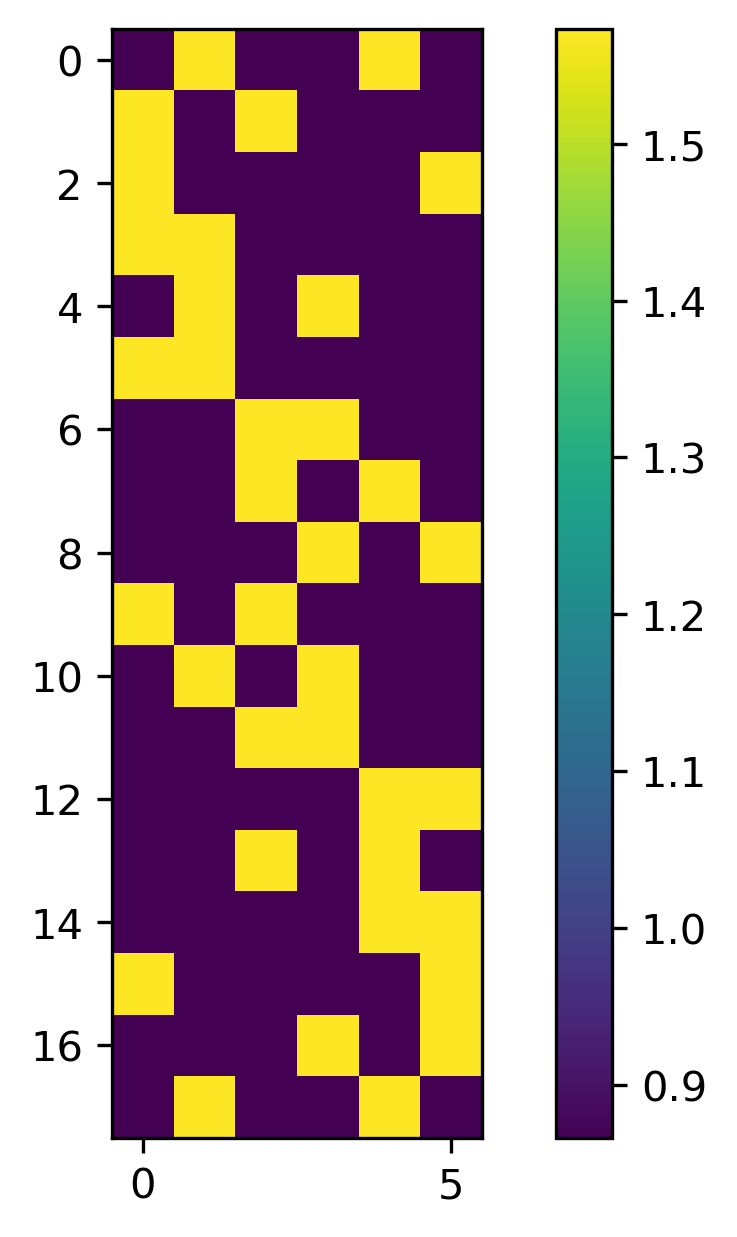

In [6]:
mpl.rcParams['figure.dpi'] =300
plt.imshow(adv.matrix)
plt.colorbar()
plt.savefig('bigadv.png')

In [7]:
def to_str(L):
    return ''.join(str(e) for e in L)

def get_equiv_classes(adv):
    equiv_classes = {}
    for yes in range(adv.matrix.shape[0]):
        for no in range(adv.matrix.shape[1]):
            adv_val = np.round(adv.matrix[yes, no], 5)
            if adv_val not in equiv_classes:
                equiv_classes[adv_val] = [(to_str(adv.problem.yes_instances[yes]), (to_str(adv.problem.no_instances[no])))]
            else:
                equiv_classes[adv_val].append((to_str(adv.problem.yes_instances[yes]), (to_str(adv.problem.no_instances[no]))))
    return equiv_classes

def hamming_dist(a, b):
    return len([i for i in range(len(a)) if a[i]!=b[i]])

classes = get_equiv_classes(adv)
for val, pair in classes.items():
    print(set(hamming_dist(a, b) for a,b in pair))
    print(val, pair)
    print()

{2, 3}
0.86603 [('001', '012'), ('001', '102'), ('001', '120'), ('001', '210'), ('002', '021'), ('002', '120'), ('002', '201'), ('002', '210'), ('010', '021'), ('010', '102'), ('010', '120'), ('010', '201'), ('011', '102'), ('011', '120'), ('011', '201'), ('011', '210'), ('020', '012'), ('020', '102'), ('020', '201'), ('020', '210'), ('022', '102'), ('022', '120'), ('022', '201'), ('022', '210'), ('100', '012'), ('100', '021'), ('100', '201'), ('100', '210'), ('101', '012'), ('101', '021'), ('101', '120'), ('101', '210'), ('110', '012'), ('110', '021'), ('110', '102'), ('110', '201'), ('112', '021'), ('112', '120'), ('112', '201'), ('112', '210'), ('121', '012'), ('121', '102'), ('121', '201'), ('121', '210'), ('122', '012'), ('122', '021'), ('122', '201'), ('122', '210'), ('200', '012'), ('200', '021'), ('200', '102'), ('200', '120'), ('202', '012'), ('202', '021'), ('202', '120'), ('202', '210'), ('211', '012'), ('211', '021'), ('211', '102'), ('211', '120'), ('212', '021'), ('212', 

In [8]:
for val, pair in classes.items():
    if len(pair):
        print(val, pair)

0.86603 [('001', '012'), ('001', '102'), ('001', '120'), ('001', '210'), ('002', '021'), ('002', '120'), ('002', '201'), ('002', '210'), ('010', '021'), ('010', '102'), ('010', '120'), ('010', '201'), ('011', '102'), ('011', '120'), ('011', '201'), ('011', '210'), ('020', '012'), ('020', '102'), ('020', '201'), ('020', '210'), ('022', '102'), ('022', '120'), ('022', '201'), ('022', '210'), ('100', '012'), ('100', '021'), ('100', '201'), ('100', '210'), ('101', '012'), ('101', '021'), ('101', '120'), ('101', '210'), ('110', '012'), ('110', '021'), ('110', '102'), ('110', '201'), ('112', '021'), ('112', '120'), ('112', '201'), ('112', '210'), ('121', '012'), ('121', '102'), ('121', '201'), ('121', '210'), ('122', '012'), ('122', '021'), ('122', '201'), ('122', '210'), ('200', '012'), ('200', '021'), ('200', '102'), ('200', '120'), ('202', '012'), ('202', '021'), ('202', '120'), ('202', '210'), ('211', '012'), ('211', '021'), ('211', '102'), ('211', '120'), ('212', '021'), ('212', '102'),

In [9]:
np.linalg.norm(adv.matrix, 2)
adv.adv()

1.6736809624375735

In [10]:
all_injective(3, 2)

2


[((1, 2), (1, 0)),
 ((0, 2), (1, 0)),
 ((1, 2), (1, 2)),
 ((0, 1), (1, 0)),
 ((0, 2), (1, 2)),
 ((0, 1), (1, 2)),
 ((1, 2), (0, 2)),
 ((0, 2), (0, 2)),
 ((0, 2), (2, 1)),
 ((1, 2), (2, 1)),
 ((0, 1), (0, 2)),
 ((0, 1), (2, 1)),
 ((0, 2), (0, 1)),
 ((0, 2), (2, 0)),
 ((1, 2), (0, 1)),
 ((1, 2), (2, 0)),
 ((0, 1), (2, 0)),
 ((0, 1), (0, 1))]

In [11]:
for i, o in all_injective(3, 2):
    print(i, o)

2
(1, 2) (1, 0)
(0, 2) (1, 0)
(1, 2) (1, 2)
(0, 1) (1, 0)
(0, 2) (1, 2)
(0, 1) (1, 2)
(1, 2) (0, 2)
(0, 2) (0, 2)
(0, 2) (2, 1)
(1, 2) (2, 1)
(0, 1) (0, 2)
(0, 1) (2, 1)
(0, 2) (0, 1)
(0, 2) (2, 0)
(1, 2) (0, 1)
(1, 2) (2, 0)
(0, 1) (2, 0)
(0, 1) (0, 1)


In [12]:
ez_adv = Adversary(problem, lambda yes, no: 1 if hamming_dist(yes, no)==1 else 0)

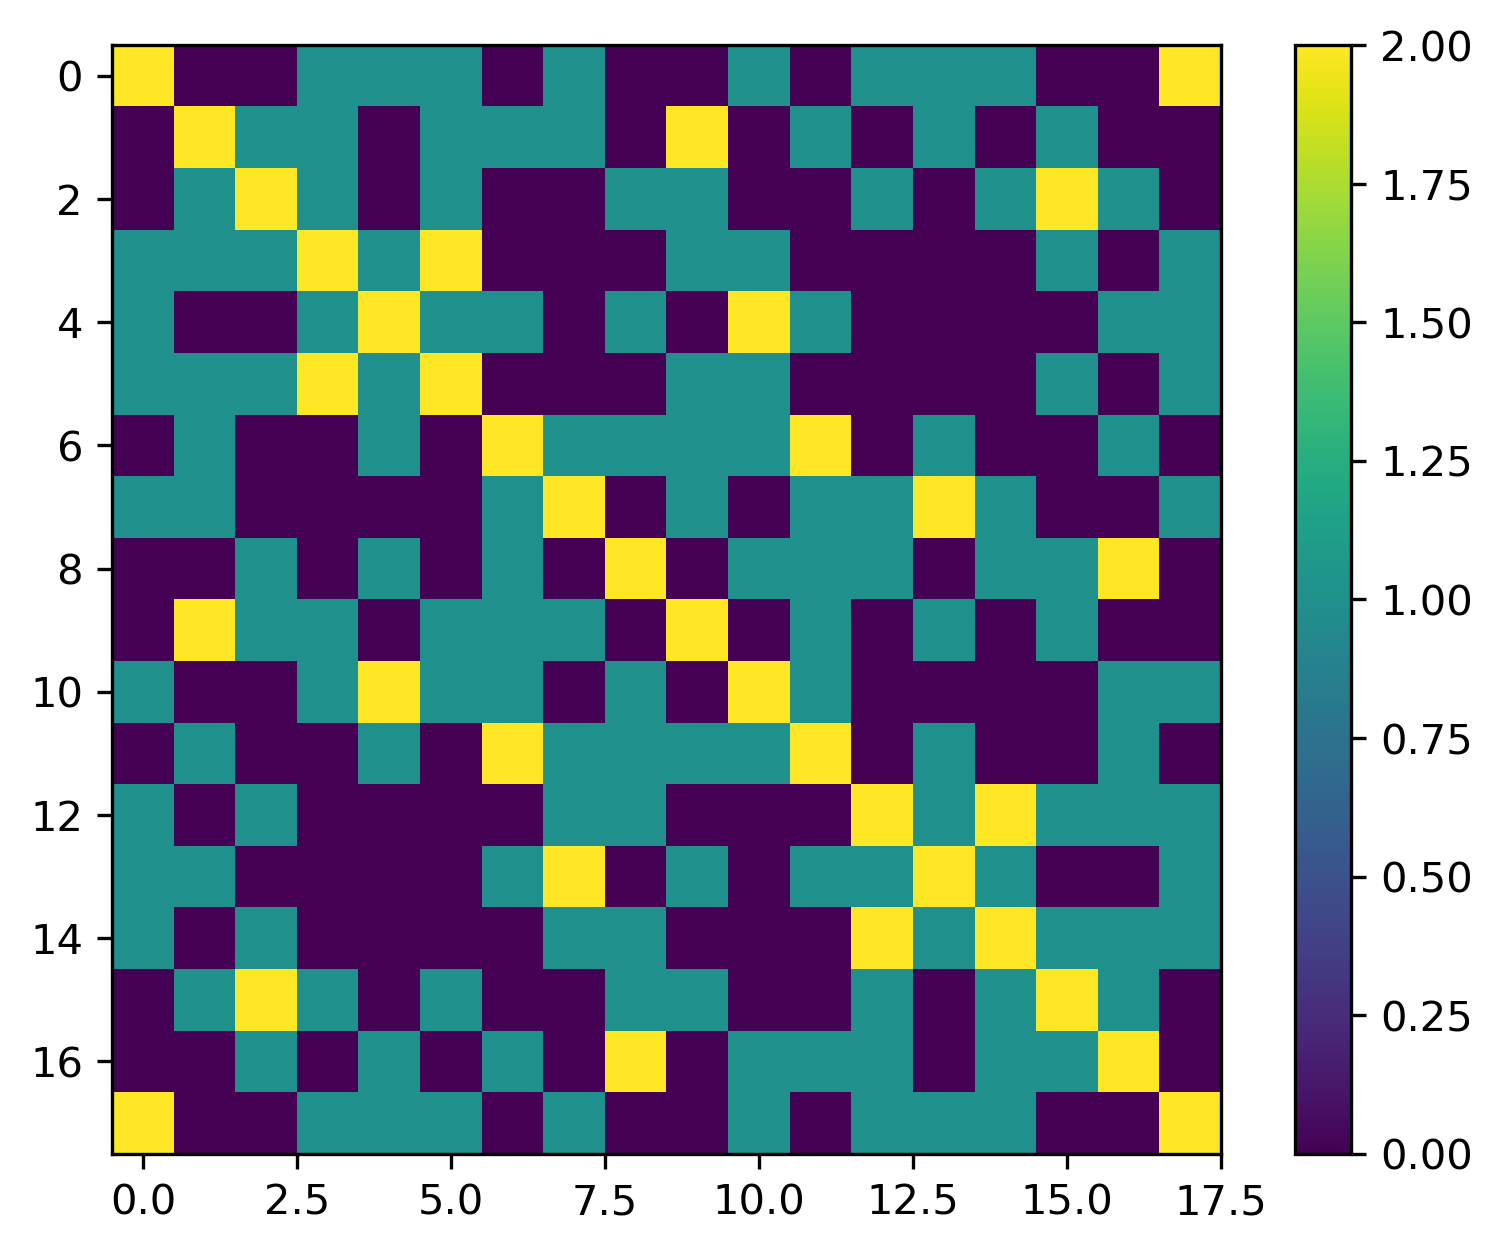

In [13]:
plt.imshow(ez_adv.matrix @ ez_adv.matrix.T)
plt.colorbar()
# np.linalg.eig(ez_adv.matrpok

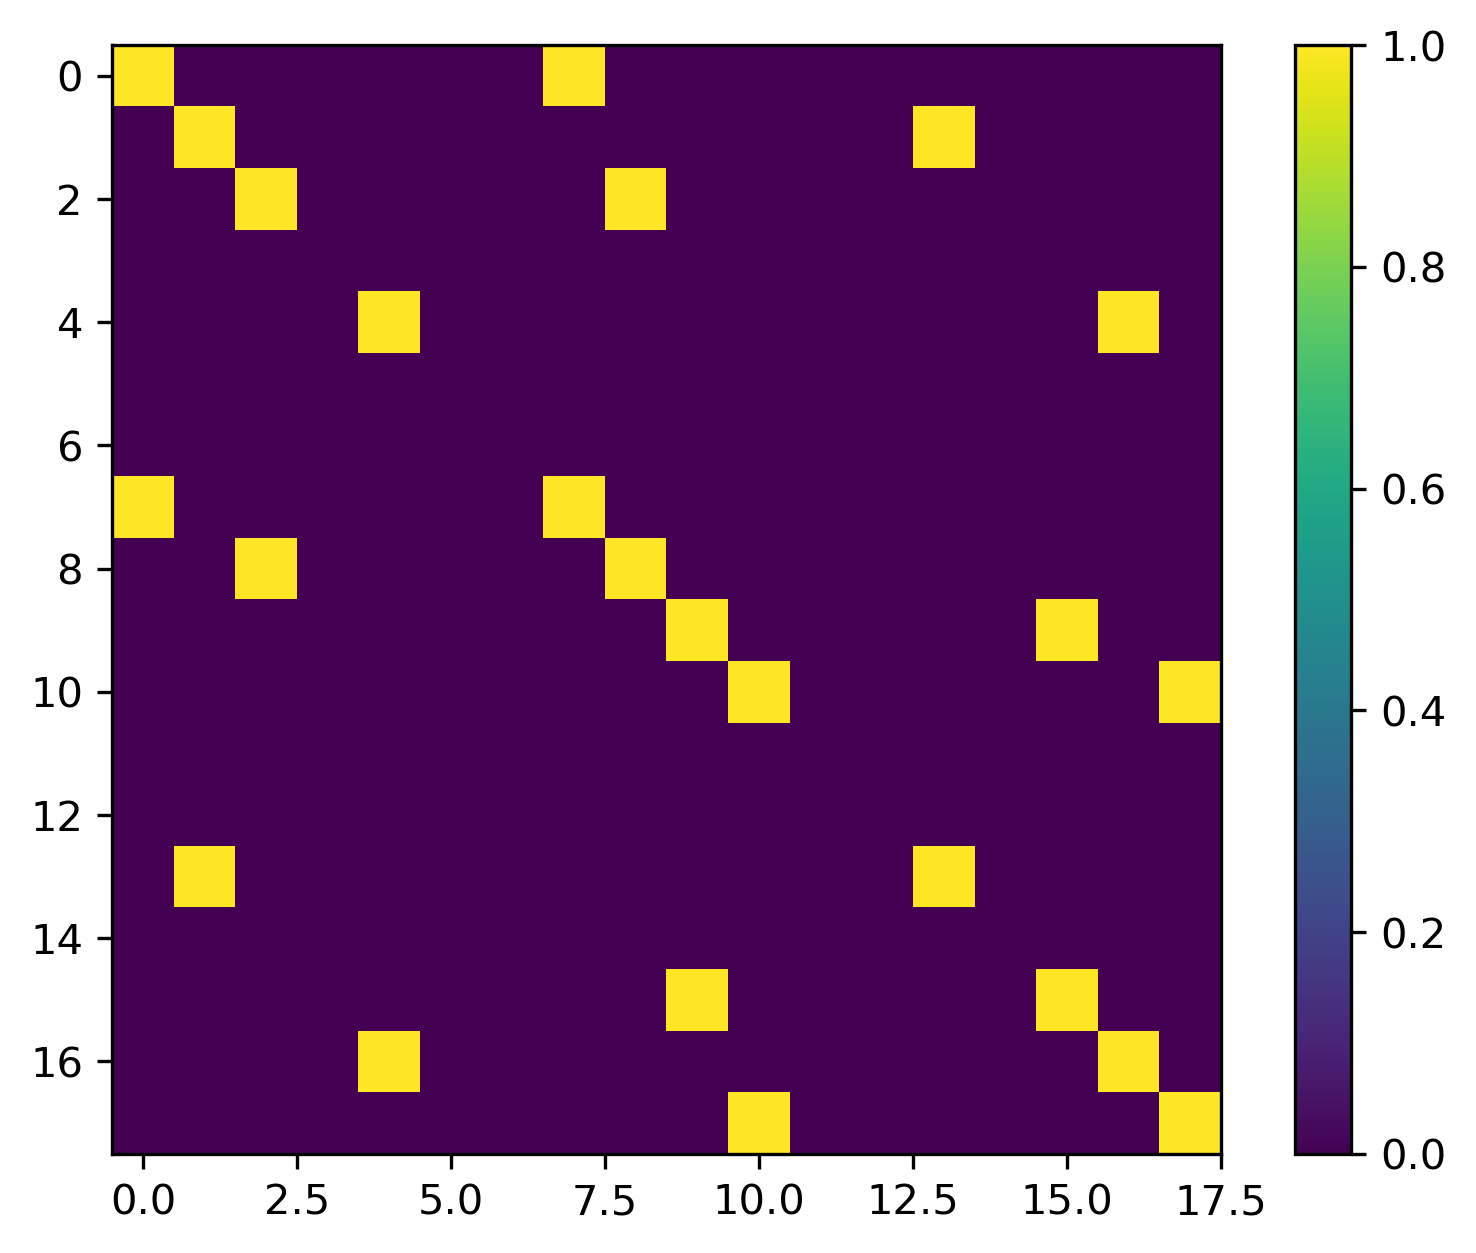

In [14]:
plt.imshow(ez_adv.partial_matrix(0)@ ez_adv.partial_matrix(0).T)
# plt.imshow(ez_adv.partial_matrix(0))
plt.colorbar()

In [15]:
problem = ED(3)
v, L, M = adv_solver(problem)
print(v)

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
2.468401725506153


In [16]:
v, X = span_solver(problem)
print(v)

2.4684072200752283


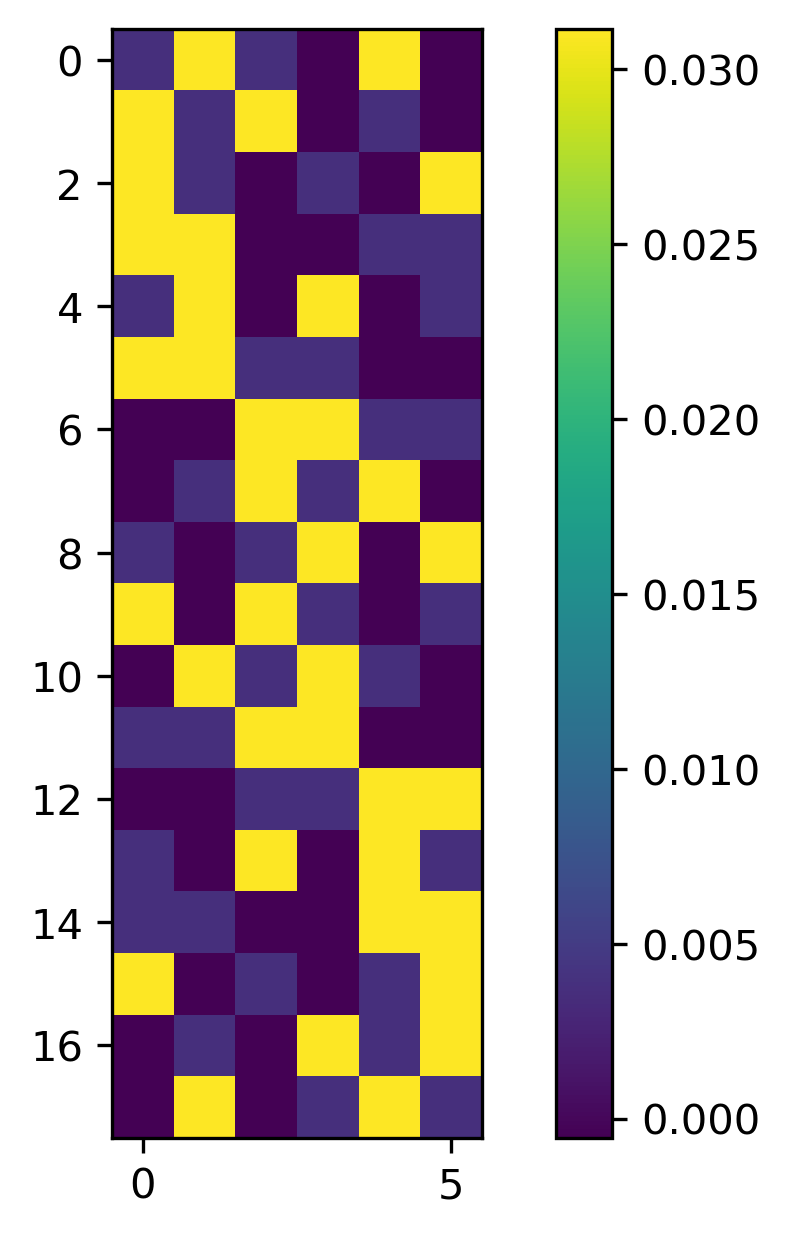

In [17]:
plt.imshow(L[problem.no_len:, :problem.no_len])
plt.colorbar()
plt.savefig('opt_mat.png')

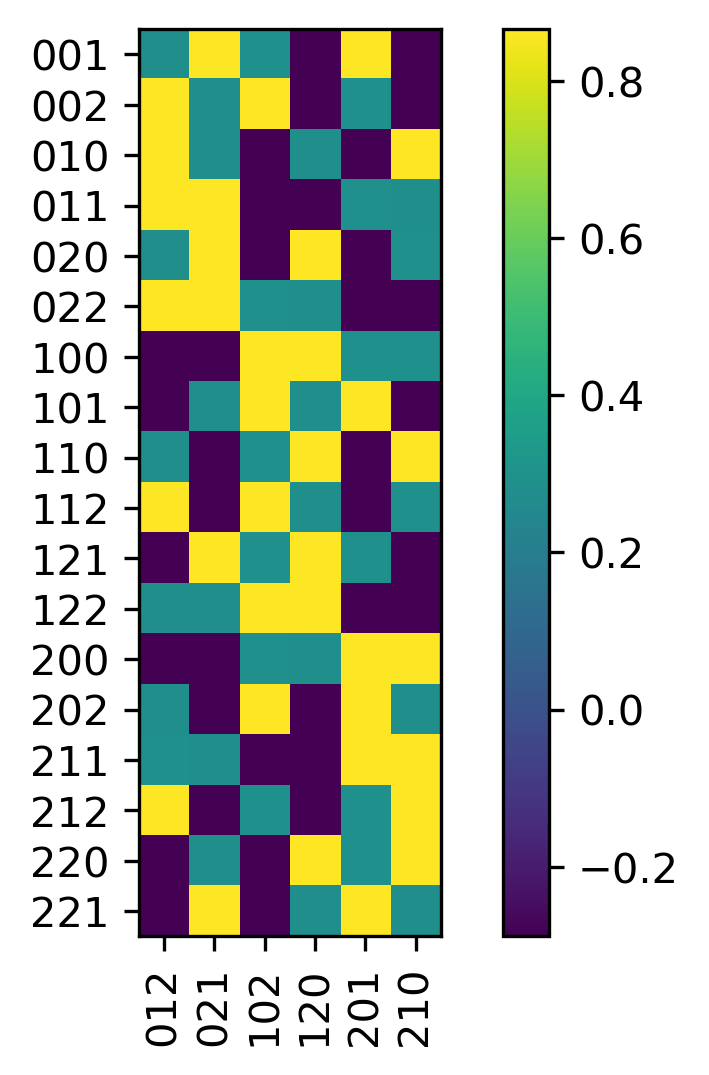

In [30]:
adv.visualize_matrix(save='ros_mat.png')

In [19]:
get_equiv_classes(adv)

{0.86603: [('001', '012'),
  ('001', '102'),
  ('001', '120'),
  ('001', '210'),
  ('002', '021'),
  ('002', '120'),
  ('002', '201'),
  ('002', '210'),
  ('010', '021'),
  ('010', '102'),
  ('010', '120'),
  ('010', '201'),
  ('011', '102'),
  ('011', '120'),
  ('011', '201'),
  ('011', '210'),
  ('020', '012'),
  ('020', '102'),
  ('020', '201'),
  ('020', '210'),
  ('022', '102'),
  ('022', '120'),
  ('022', '201'),
  ('022', '210'),
  ('100', '012'),
  ('100', '021'),
  ('100', '201'),
  ('100', '210'),
  ('101', '012'),
  ('101', '021'),
  ('101', '120'),
  ('101', '210'),
  ('110', '012'),
  ('110', '021'),
  ('110', '102'),
  ('110', '201'),
  ('112', '021'),
  ('112', '120'),
  ('112', '201'),
  ('112', '210'),
  ('121', '012'),
  ('121', '102'),
  ('121', '201'),
  ('121', '210'),
  ('122', '012'),
  ('122', '021'),
  ('122', '201'),
  ('122', '210'),
  ('200', '012'),
  ('200', '021'),
  ('200', '102'),
  ('200', '120'),
  ('202', '012'),
  ('202', '021'),
  ('202', '120'),
 

In [20]:
opt_mat = L[problem.no_len:, :problem.no_len]
print(opt_mat[0][1])
opt_adv = Adversary(problem, lambda yes, no: opt_mat[problem.yes_instance_to_index[yes]][problem.no_instance_to_index[no]])

0.03114742229779991


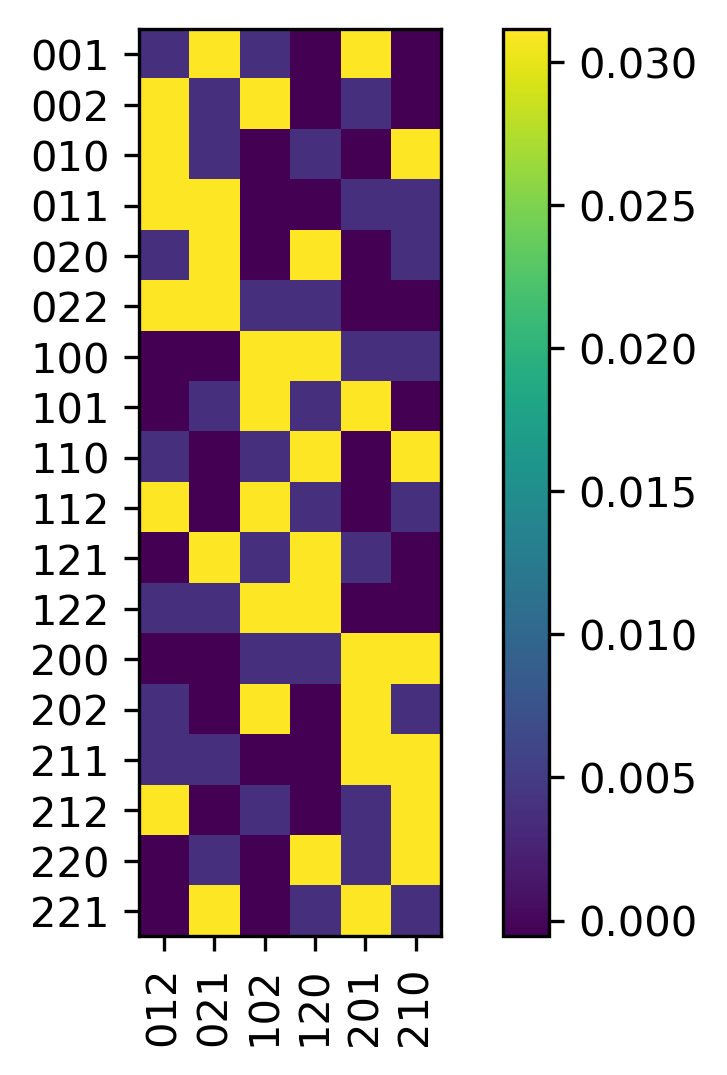

In [23]:
opt_adv.visualize_matrix(save='opt_mat.png')

In [22]:
get_equiv_classes(opt_adv)

{0.00369: [('001', '012'),
  ('001', '102'),
  ('002', '021'),
  ('002', '201'),
  ('010', '021'),
  ('010', '120'),
  ('011', '201'),
  ('011', '210'),
  ('020', '012'),
  ('020', '210'),
  ('022', '102'),
  ('022', '120'),
  ('100', '201'),
  ('100', '210'),
  ('101', '021'),
  ('101', '120'),
  ('110', '012'),
  ('110', '102'),
  ('112', '120'),
  ('112', '210'),
  ('121', '102'),
  ('121', '201'),
  ('122', '012'),
  ('122', '021'),
  ('200', '102'),
  ('200', '120'),
  ('202', '012'),
  ('202', '210'),
  ('211', '012'),
  ('211', '021'),
  ('212', '102'),
  ('212', '201'),
  ('220', '021'),
  ('220', '201'),
  ('221', '120'),
  ('221', '210')],
 0.03115: [('001', '021'),
  ('001', '201'),
  ('002', '012'),
  ('002', '102'),
  ('010', '012'),
  ('010', '210'),
  ('011', '012'),
  ('011', '021'),
  ('020', '021'),
  ('020', '120'),
  ('022', '012'),
  ('022', '021'),
  ('100', '102'),
  ('100', '120'),
  ('101', '102'),
  ('101', '201'),
  ('110', '120'),
  ('110', '210'),
  ('112',